# Transformer 구현
 - [딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/31379)
 - https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/blob/master/6.CHATBOT/6.5.transformer.ipynb

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Positional Encoding
 - RNN과 달리 트랜스포머의 입력은 단어 하나하나 순차적으로 넣지 않고 한번에 넣어준다 (행렬와 같이)
 - 따라서 입력에 순서 정보를 넣어줄 필요성이 있음
 - => 각 단어의 임베딩 벡터에 위치 정보들을 더해 모델의 입력으로 사용
 - => **입력 행렬**과 같은 크기의 **포지셔널 인코딩 행렬을 더해준다**
 - Positional Encoding
  - $PE_{(pos, 2i)} = sin(\frac{pos}{10000^{2i/d_{model}}})$
  - $PE_{(pos, 2i+1)} = cos(\frac{pos}{10000^{2i/d_{model}}})$
 - (참고) positional encoding에 대한 설명 [(링크)](https://gaussian37.github.io/dl-concept-positional_encoding/) 또는 [(여기)](https://www.blossominkyung.com/deeplearning/transfomer-positional-encoding)

In [2]:
# pos: 입력 문장의 길이
# d_model: 임베딩 벡터의 차원
def get_angles(pos, i, d_model):
    angles = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))
    return pos * angles

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],    
        np.arange(d_model)[np.newaxis, :],
        d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
        
    return tf.cast(pos_encoding, dtype=tf.float32)

In [3]:
position = 40
np.arange(position)[np.newaxis, :]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39]])

(1, 50, 512)


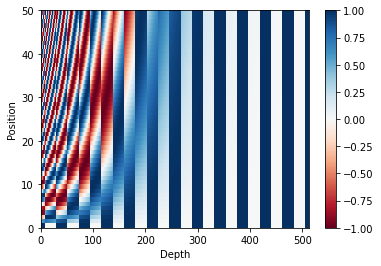

In [4]:
# positional encoding 테스트
pos = 50
d_model = 512
pos_encoding = positional_encoding(pos, d_model)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [5]:
# pos: 입력 문장의 길이
# d_model: 임베딩 벡터의 차원
class PositionalEncoding(tf.keras.layers.Layer):
    '''
    문장 행렬의 크기와 같은 pos_encoding 행렬을 만들어준 뒤 
    call부분에서 inputs에 pos_encoding행렬을 더해준다.
    
    Return:
    inputs + pos_encoding
    
    '''
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, pos, i, d_model):
        angles = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))
        return pos * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = get_angles(
            pos=np.arange(position)[:, np.newaxis],
            i=np.arange(d_model)[np.newaxis, :],
            d_model=d_model)
        '''
        get_angles의 입력으로
        pos => (seq_len, 1)
        i => (1, embd_i)로 차원을 늘려준 뒤 전달하면 브로드캐스팅을 통해
        (seq_len, embd_i)크기를 가진 pos_encoding 행렬을 만들어줄 수 있다
        '''
        
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        
        pos_encoding = angle_rads[np.newaxis, ...]
        
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    # Input에 포지셔널 인코딩 행렬을 더해준다.
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Scaled Dot Product Attention
 - $Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$

In [6]:
def scaledDotProductAttention(query, key, value, mask):
    '''
    Scaled dot product attention을 계산하는 함수
    
    Args:
    query, key, value, mask
    query: query의 shape = (batch_size, num_heads, query의 문장길이, d_model/num_head),
    key:   key의   shape = (batch_size, num_heads, key의 문장길이, d_model/num_head),
    value: value의 shape = (batch_size, num_heads, value의 문장길이, d_model/num_head),
    mask:  padding mask = (batch_size, 1, 1, key의 문장길이)
    
    d_model/num_head => d_k
    이 함수에서 받는 query의 shape는 (query의 문장길이, d_k)
     
    Returns:
    output, attetion_weights
    '''
    
    # 어텐션 스코어, Q와 K의 dot product
    qk = tf.matmul(query, key, transpose_b=True)
    
    # 스케일링 (sqrt(dk)로 나눔)
    # dk = d_model / num_head
    scale = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = qk / tf.math.sqrt(scale)
    
    # 마스킹
    if mask is not None:
        logits += (mask * -1e9)
        
    # 어텐션 weights
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # output: (batch_size, num_heads, query 문장길이, d_k)
    output = tf.matmul(attention_weights, value)
    
    return output, attention_weights

In [7]:
# 함수테스트
# 임의의 q, k, v 행렬 생성
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)   # (4, 3)
temp_v = tf.constant([[1, 0], 
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)    # (4, 2)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)    # (1, 3)

temp_out, temp_attn_weight = scaledDotProductAttention(temp_q, temp_k, temp_v, None)
print(temp_attn_weight)
print(temp_out)
print()

temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn_weight = scaledDotProductAttention(temp_q, temp_k, temp_v, None)
print(temp_attn_weight)
print(temp_out)
print()

temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn_weight = scaledDotProductAttention(temp_q, temp_k, temp_v, None)
print(temp_attn_weight) 
print(temp_out)

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### Multihead Attention

In [8]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.d_model = d_model
        self.num_heads = num_heads
        
        assert self.d_model % self.num_heads == 0    # d_k는 나머지가 0이어야 한다
        
        # depth = d_model // num_heads (논문기준 64 = 512 // 8)
        # deqth == d_k
        self.depth = self.d_model // self.num_heads
        
        # WQ, WK, WV 정의
        # 문장행렬에 WQ, WK, WV가 곱해져 Q, K, V가 만들어진다
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        # WO 정의
        # => Attention Heads들의 Concat결과에 곱해지는 층
        self.dense = tf.keras.layers.Dense(d_model)
    

    def split_heads(self, inputs, batch_size):
        '''
        Q, K, V를 num_heads 수만큼 split하는 함수
        
        ex) query = (batch_size, seq_len, d_model) = (2, 4, 16)일때
        num_heads = 4 이라면
        => (batch_size, -1, num_heads, d_k) = (2, 1, 4, 4)로 reshape
        ## => (batch_size, num_heads, 1, d_k)로 리턴 ##
        
        Return:
        (batch_size, num_heads, seq_len, depth)
        '''
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])


    def call(self, q, k, v):
        q, k, v, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(q)[0]
     
        # 1) Q, K, V 생성   
        ## 인코더(k,v) - 디코더(q) 어텐션에서는 query 길이와 key, value길이가 다를 수 있다
        query = self.wq(q)    # query : (batch_size, seq_len_q, d_model)
        key = self.wk(k)      # key   : (batch_size, seq_len_k, d_model)
        value = self.wv(v)    # value : (batch_size, seq_len_v, d_model)
        
        # 2) 헤드 나누기
        query = self.split_heads(query, batch_size)    # query : (batch_size, num_heads, seq_len_q, depth)
        key = self.split_heads(key, batch_size)        # key : (batch_size, num_heads, seq_len_k, depth)
        value = self.split_heads(value, batch_size)    # value : (batch_size, num_heads, seq_len_v, depth)
        
        # 3) 스케일 닷 프로덕트 어텐션
        # (batch_size, num_heads, seq_len_q, d_k)
        scaled_attention, _ = scaledDotProductAttention(query, key, value, mask)
        
        # (batch_size, seq_len_q, num_heads, d_k) => ??
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 4) 헤드 연결
        # (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention, shape=(batch_size, -1, self.d_model))
        
        # 5) WO에 해당하는 dense layer 통과
        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        
        return output

In [9]:
# split head와 scaled dot 과정에서 transpose perm을 해주는 이유?
# => 아마 연산과정에서 병렬처리를 위해?
# => 결과적으로 연산 후 처음 query와 같은 shape와 값들로 돌아온다
import tensorflow as tf

batch_size = 2
seq_len = 4
d_model = 16
num_heads = 4

temp = tf.constant(range(batch_size * seq_len * d_model))
temp

query = tf.reshape(temp, shape=(batch_size, seq_len, d_model))    # 128
query

s_query = tf.reshape(query, shape=(batch_size, -1, num_heads, d_model//num_heads))
s_query

trans_query = tf.transpose(s_query, perm=[0, 2, 1, 3])
trans_query

re_trans_query = tf.transpose(trans_query, perm=[0, 2, 1, 3])
re_trans_query

connect_query = tf.reshape(re_trans_query, shape=(batch_size, -1, d_model))
connect_query


<tf.Tensor: shape=(2, 4, 16), dtype=int32, numpy=
array([[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
          12,  13,  14,  15],
        [ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31],
        [ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
          44,  45,  46,  47],
        [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
          60,  61,  62,  63]],

       [[ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
          76,  77,  78,  79],
        [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
          92,  93,  94,  95],
        [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
         108, 109, 110, 111],
        [112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
         124, 125, 126, 127]]])>

### Padding Mask

In [10]:
def createPaddingMask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)    # tf.math.equal(x, 0): x가 0인 경우에는 1, 그렇지 않으면 0으로 변환
    return mask[:, tf.newaxis, tf.newaxis, :]    # (batch_size, 1, 1, key의 문장길이)

In [11]:
# 패딩마스크 테스트
print(createPaddingMask([[1, 21, 645, 0, 0]]))

# MHA 부분에서 logit에 mask에 매우작은 수를 더해준다
# padding mask를 만들어 매우 작은 음수값 -1e9를 곱해주고 이를 logit 행렬에 더해주어 마스킹 구현
# if mask is not None:
#     logits += (mask * -1e9)

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


### Position-wise Feed-Foward Networks

In [12]:
# 논문에서 dff = 2048
outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
outputs = tf.keras.layers.Dense(units=d_model)(outputs)
# def FFN(dff, d_model):
#     return tf.keras.Sequential([
#         tf.keras.layers.Dense(units=dff, activation='relu'),
#         tf.keras.layers.Dense(units=d_model)])

NameError: name 'dff' is not defined

### Residual Connection & Layer Normalization
 - Residual connection
     - sub층의 입력과 출력을 더하는 연결
     - $H(x)= x + F(x)$
 - Layer Normalization
     - $\hat{x}_{i,k} = \frac{x_{i,k} - \mu_{i}}{\sqrt{\sigma^2_i + \epsilon}}$
     - $LayerNorm(x_i) = \gamma \hat{x}_i + \beta$

In [13]:
# attention = ...
# outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

### EncoderLayer

In [14]:
# MHA - Dropout - Add&Norm - FFN - Dropout - ADD&Norm
def encoder_layer(dff, d_model, num_heads, dropout, name='encoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')    # q, k, v 생성
    
    # 패딩마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 멀티헤드 어텐션 (첫번째 서브레이어)
    attention = MultiHeadAttention(d_model, num_heads, name='attention')({'query': inputs, 'key': inputs, 'value': inputs, 'mask': padding_mask})
    
    # 드롭아웃, 잔차연결 + 정규화
    output1 = tf.keras.layers.Dropout(rate=dropout)(attention)
    output1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + inputs)
    
    # FFN
    output2 = tf.keras.layers.Dense(units=dff, activation='relu')(output1)
    output2 = tf.keras.layers.Dense(units=d_model)(output2)
    
    # 드롭아웃, 잔차연결 + 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(output2)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(output1 + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=output2, name=name)

### Encoder

In [15]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='encoder'):
    inputs = tf.keras.Input(shape=(None,), name='input')
    
    # 인코더는 패딩마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # 인코더 쌓기 num_layers수 만큼
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, name='encoder_layer_{}'.format(i))([outputs, padding_mask])
        
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Look Ahead Mask

In [16]:
# 룩 어헤드 마스크
def createLookAheadMask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = createPaddingMask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [17]:
print(createLookAheadMask([[1, 2, 0, 4, 5]]))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### DecoderLayer

In [18]:
def decoder_layer(dff, d_model, num_heads, dropout, name='decoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    # 룩어헤드 & 패딩 마스크
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')    # for 첫번째 서브층
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')    # for 두번째 서브층
    
    # 멀티 헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name='attention_1')(inputs={'query': inputs, 'key': inputs, 'value': inputs, 'mask': look_ahead_mask})
    
    # 잔차연결 & 정규화
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    # 멀티헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name='attention_2')(inputs={'query': attention1, 'key': enc_outputs, 'value': enc_outputs, 'mask': padding_mask})    # query != key == value
    
    # 드롭아웃 + 잔차열결 & 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    # FFN (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 드롭아웃 + 잔차연결 & 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

### Decoder

In [19]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    # 룩어헤드 마스크, 패딩마스크
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # 디코더 쌓기. num_layers만큼
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, name=f'decoder_layer_{i}',)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

### Transformer Model

In [20]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='transformer'):
    # 인코더 입력
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    # 디코더 입력
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    
    # 인코더 패딩마스크
    enc_padding_mask = tf.keras.layers.Lambda(createPaddingMask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    
    # 디코더 룩어헤드 마스크 (for 첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(createLookAheadMask, output_shape=(1, None, None,), name='look_ahead_mask')(dec_inputs)
    
    # 디코더 패딩마스크 (for 두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(createPaddingMask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)
    
    # 인코더의 출력 -> 디코더로 전달
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[inputs, enc_padding_mask]) # 인코더 입력: [문장, 패딩마스크]
    
    # 디코더의 출력 -> 출력층으로 전달
    # 디코더 입력 : [디코더 입력, 인코더 출력, 룩어헤드 마스크, 디코더 패딩마스크]
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### Hyperparameter

In [21]:
# vocab_size는 임의로 9000
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

### Loss Function
 - 다중 클래스 분류 문제 -> sparse categorical crossentropy

In [29]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    # -log(onehot(y_true)) * y_pred
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)    # "reduction: none" return tensor
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)    # elementwise multiply
    
    return tf.reduce_mean(loss)    # reduce_mean: 전체원소의 합을 개수로 나눈값 리턴

### Training
 - 트랜스포머는 사용자가 정한 단계(warmup_step)까지는 학습률을 증가시켰다가 단계에 이르면 학습률을 점차적으로 떨어트리는 방식을 사용
 - step < warmup_steps: 학습률 선형적으로 증가
 - step >= warmup_steps: 학습률 감소
 - Learning rate warmup이란?
     - 작은 learning rate로 시작해서 학습 과정이 안정되면 regular learning rate로 사용하는 방법
     - 초기 training시 parameter들이 보통 random initialized 되어있어 final solution과 차이가 있다. 이때 너무 큰 learning rate사용시 numerical instability가 발생가능
     - [Bag of Tricks for Image Classification with Convolutional Neural Networks (2018)](https://arxiv.org/abs/1812.01187)

In [38]:
# step: optimizer가 매개변수를 업데이트하는 횟수
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)    # reciprocal of square root
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

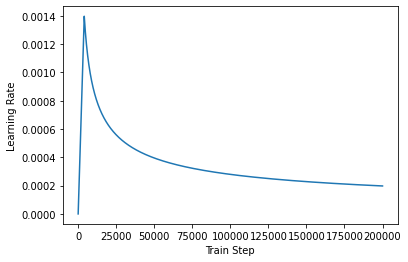

In [39]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")